In [112]:
import pandas as pd
import urllib3,certifi
import matplotlib.pyplot as plt

#### Data load from Naver finances

In [2]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다.
code_df = code_df[['회사명', '종목코드']]

# 한글로된 컬럼명을 영어로 바꿔준다.
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

In [3]:
code_df.head()

,name,code
0,CJ,001040
1,HDC,012630
2,HSD엔진,082740
3,KG케미칼,001390
4,LG이노텍,011070


In [4]:
def get_code (item_name, code_df=code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    return code

In [8]:
get_code('카카오')

'035720'

In [9]:
# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    url = 'https://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)

    return url

def get_stock_data(item_name, code_df = code_df, n_pages=20):
    url = get_url(item_name, code_df)

    #Force certificate check and use certifi to handle the certificate. 
    https = urllib3.PoolManager( cert_reqs='CERT_REQUIRED',
    ca_certs=certifi.where(),)  

    # 일자 데이터를 담을 df라는 DataFrame 정의
    df = pd.DataFrame()

    # 1페이지에서 20페이지의 데이터만 가져오기
    for page in range(1, n_pages + 1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        #print('url: ', pg_url)
        https_url = https.urlopen('GET', pg_url) #' https://naver.com')  
        df = df.append(pd.read_html(https_url.data, header=0)[0], ignore_index=True)

    # df.dropna()를 이용해 결측값 있는 행 제거
    df = df.dropna()
    return df

In [10]:
#code_df
get_code('카카오')

'035720'

In [141]:
df_naver = get_stock_data('NAVER', n_pages=60)

In [142]:
df_kakao = get_stock_data('카카오', n_pages=60)

In [192]:
df_kakao.head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
0,2018.08.10,128000,2500,125500,129500,124000,1263656
1,2018.08.09,125500,6500,121000,126000,119500,1622449
2,2018.08.08,119000,1000,122000,124500,118000,1216684


In [193]:
df_naver.head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
0,2018.08.10,771000,8000,777000,782000,770000,69051
1,2018.08.09,779000,29000,753000,779000,745000,133034
2,2018.08.08,750000,6000,742000,756000,742000,62482


In [143]:
#df_kakao.info()
#df_naver.info()

In [179]:
import matplotlib.pyplot as plt

In [200]:
df2 = pd.DataFrame()
#df2['date'] = df_naver['날짜']
#df2['naver'] =  df_naver['종가']
df2['naver'] =  df_naver['시가']
df2['kakao'] = df_kakao['시가']

In [201]:
df2['date'] = df_naver['날짜']
df2.date = pd.to_datetime(df2.date)
df2 =df2.set_index('date')

In [204]:
df2 = df2.sort_index()

In [205]:
df2.head(3)

,naver,kakao
date,,
2016-03-04,615000,102400
2016-03-07,615000,104100
2016-03-08,588000,106600


In [206]:
df2['ratio'] = df2['naver'] / df2['kakao']

In [213]:
df2['avg_ratio'] = df2['ratio'].rolling(window=20, min_periods=1).mean()

In [215]:
df2.head(3)

,naver,kakao,ratio,avg_ratio
date,,,,
2016-03-04,615000,102400,6.005859,6.005859
2016-03-07,615000,104100,5.907781,5.956820
2016-03-08,588000,106600,5.515947,5.809863


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


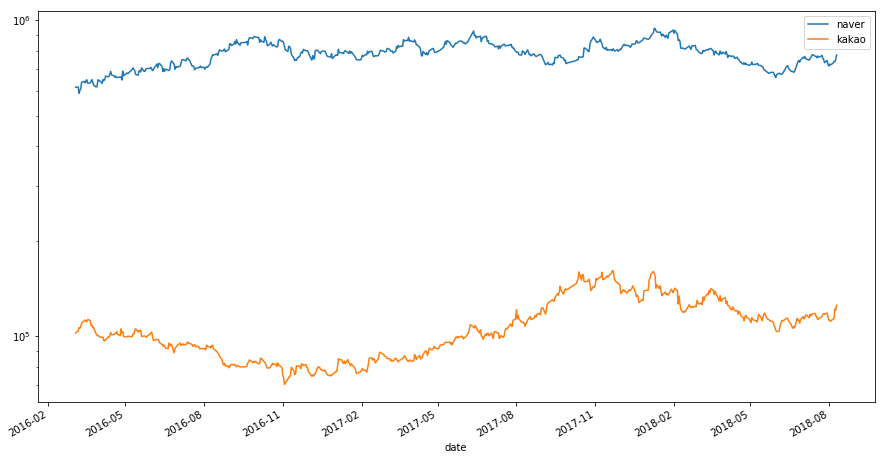

In [216]:
#df2.adropna()
#plt.figure(figsize=(15, 8))
df2.plot(y = ['naver', 'kakao'], logy=True, figsize = (15, 8))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


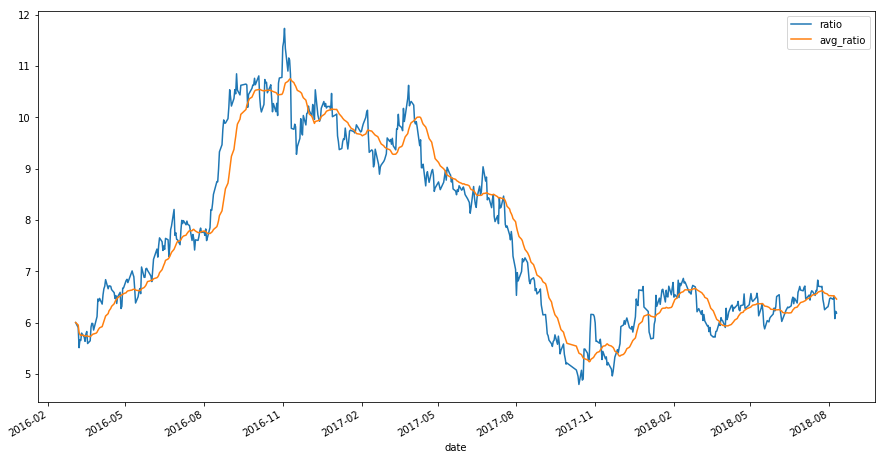

In [217]:
df2.plot(y=['ratio', 'avg_ratio'], figsize = (15, 8))

In [218]:
df2.corr()

,naver,kakao,ratio,avg_ratio
naver,1.000000,0.111178,0.357093,0.343525
kakao,0.111178,1.000000,-0.873408,-0.845714
ratio,0.357093,-0.873408,1.000000,0.967903
avg_ratio,0.343525,-0.845714,0.967903,1.000000


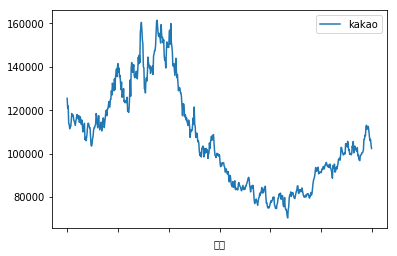

In [151]:
df2.plot(y='kakao')

In [138]:
df2['diff'] = df2['naver'] - df2['kakao']

In [139]:
df2.head(3)

,naver,kakao,ratio,diff
날짜,,,,
2018-08-10,777000,125500,6.191235,651500
2018-08-09,753000,121000,6.223140,632000
2018-08-08,742000,122000,6.081967,620000


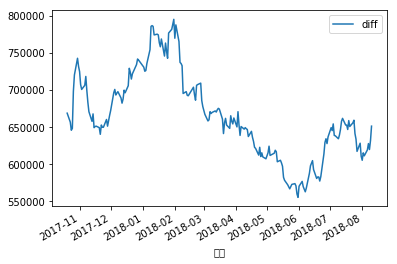

In [140]:
df2.plot(y='diff')